<a href="https://colab.research.google.com/github/R21Rash/tea-leaf-disease-detection/blob/master/mobilenet_to_tea_leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tea Leaf Disease Detection - Google Colab

This notebook implements a complete tea leaf disease detection system using MobileNetV2 with transfer learning.

**Dataset**: TeaLeafBD from Kaggle - Sri Lankan tea leaf diseases

**Model**: MobileNetV2 (transfer learning)

**Classes**:
- Tea algal leaf spot
- Brown Blight
- Gray Blight
- Helopeltis
- Red spider
- Green mirid bug
- Healthy leaf


## 1. Setup and Installation


In [5]:
# Install required packages
%pip install -q torch torchvision torchaudio
%pip install -q numpy pandas matplotlib scikit-learn opencv-python tqdm pyyaml
%pip install -q kaggle

# Verify GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4
CUDA memory: 15.8 GB


## 2. Kaggle Dataset Setup

**Important**: You need to upload your Kaggle API credentials:
1. Go to your Kaggle account settings
2. Create a new API token (downloads kaggle.json)
3. Upload the kaggle.json file to this Colab session


In [3]:
# Upload kaggle.json file first, then run this cell
from google.colab import files
import os

# Upload kaggle.json
uploaded = files.upload()

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully!")


Saving kaggle.json to kaggle.json
Kaggle API configured successfully!


In [8]:
# Download the TeaLeafBD dataset
!kaggle datasets download -d bmshahriaalam/tealeafbd-tea-leaf-disease-detection

# Create the datasets directory if it doesn't exist
!mkdir -p datasets/TeaLeafBD

# Extract the dataset
!unzip -q tealeafbd-tea-leaf-disease-detection.zip -d datasets/TeaLeafBD/

# Check the dataset structure
!ls -la datasets/
!ls -la datasets/TeaLeafBD/
!ls -la datasets/TeaLeafBD/teaLeafBD/ # Check the nested directory with lowercase 't'
!ls -la datasets/TeaLeafBD/TeaLeafBD/ # Check the nested directory with uppercase 'T'

Dataset URL: https://www.kaggle.com/datasets/bmshahriaalam/tealeafbd-tea-leaf-disease-detection
License(s): CC-BY-SA-4.0
tealeafbd-tea-leaf-disease-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
total 12
drwxr-xr-x 3 root root 4096 Oct  6 09:51 .
drwxr-xr-x 1 root root 4096 Oct  6 09:51 ..
drwxr-xr-x 3 root root 4096 Oct  6 09:51 TeaLeafBD
total 12
drwxr-xr-x 3 root root 4096 Oct  6 09:51 .
drwxr-xr-x 3 root root 4096 Oct  6 09:51 ..
drwxr-xr-x 3 root root 4096 Oct  6 09:51 teaLeafBD
total 12
drwxr-xr-x 3 root root 4096 Oct  6 09:51 .
drwxr-xr-x 3 root root 4096 Oct  6 09:51 ..
drwxr-xr-x 9 root root 4096 Oct  6 09:51 teaLeafBD
ls: cannot access 'datasets/TeaLeafBD/TeaLeafBD/': No such file or directory


## 3. Dataset Preparation and Splitting


In [9]:
# Dataset splitting function (adapted from scripts/split_dataset.py)
import argparse
import os
import random
import shutil
from pathlib import Path

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def collect_images(root: Path):
    classes = []
    files = []
    # Adjusted to look for class directories within the root
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        classes.append(cls_dir.name)
        for img in cls_dir.rglob("*"):
            if img.suffix.lower() in IMG_EXTS:
                files.append((cls_dir.name, img))
    return classes, files

def split_copy(files, classes, dst: Path, train=0.8, val=0.1, test=0.1, seed=42):
    random.seed(seed)
    by_cls = {c: [] for c in classes}
    for c, p in files:
        by_cls[c].append(p)

    for c in classes:
        imgs = by_cls[c]
        random.shuffle(imgs)
        n = len(imgs)
        n_tr = int(n * train)
        n_va = int(n * val)
        parts = {
            "train": imgs[:n_tr],
            "val":   imgs[n_tr:n_tr+n_va],
            "test":  imgs[n_tr+n_va:],
        }
        for split, items in parts.items():
            outdir = dst / split / c
            outdir.mkdir(parents=True, exist_ok=True)
            for src in items:
                shutil.copy(src, outdir / src.name)

# Split the dataset
src = Path("datasets/TeaLeafBD/teaLeafBD/teaLeafBD") # Corrected source path based on ls output
dst = Path("data")

classes, files = collect_images(src)
print(f"Found {len(files)} images across {len(classes)} classes: {classes}")

# Split into train/val/test (80/10/10)
split_copy(files, classes, dst, train=0.8, val=0.1, test=0.1, seed=42)
print(f"Dataset split completed! Structure ready under: {dst}/train|val|test/<class>/")

# Show the final structure
!ls -la data/
!ls -la data/train/

Found 5276 images across 7 classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Dataset split completed! Structure ready under: data/train|val|test/<class>/
total 20
drwxr-xr-x 5 root root 4096 Oct  6 09:53 .
drwxr-xr-x 1 root root 4096 Oct  6 09:53 ..
drwxr-xr-x 9 root root 4096 Oct  6 09:53 test
drwxr-xr-x 9 root root 4096 Oct  6 09:53 train
drwxr-xr-x 9 root root 4096 Oct  6 09:53 val
total 228
drwxr-xr-x 9 root root  4096 Oct  6 09:53  .
drwxr-xr-x 5 root root  4096 Oct  6 09:53  ..
drwxr-xr-x 2 root root 20480 Oct  6 09:53 '1. Tea algal leaf spot'
drwxr-xr-x 2 root root 20480 Oct  6 09:53 '2. Brown Blight'
drwxr-xr-x 2 root root 36864 Oct  6 09:53 '3. Gray Blight'
drwxr-xr-x 2 root root 20480 Oct  6 09:53 '4. Helopeltis'
drwxr-xr-x 2 root root 20480 Oct  6 09:53 '5. Red spider'
drwxr-xr-x 2 root root 69632 Oct  6 09:53 '6. Green mirid bug'
drwxr-xr-x 2 root root 36864 Oct  6 09:53 '7. He

## 4. Model Definitions


In [10]:
# MobileNetV2 Model Definition
import torch
import torch.nn as nn
from torchvision import models

def build_mobilenet_v2(num_classes: int, freeze_backbone: bool = True):
    """
    Build MobileNetV2 model for tea leaf disease detection

    Args:
        num_classes: Number of output classes (7 for tea leaf diseases)
        freeze_backbone: Whether to freeze the backbone features

    Returns:
        MobileNetV2 model with custom classifier
    """
    # Load pre-trained MobileNetV2
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    # Freeze backbone if requested
    if freeze_backbone:
        for param in model.features.parameters():
            param.requires_grad = False

    # Replace the classifier with custom one for our number of classes
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)

    return model

print("MobileNetV2 model definition loaded successfully!")


MobileNetV2 model definition loaded successfully!


## 5. Training Functions


In [11]:
# Training functions (adapted from src/train.py)
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_data_loaders(data_dir, img_size=224, batch_size=32, num_workers=2):
    train_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_path = os.path.join(data_dir, "train")
    val_path = os.path.join(data_dir, "val")
    test_path = os.path.join(data_dir, "test")

    train_ds = datasets.ImageFolder(train_path, transform=train_tfms)
    val_ds = datasets.ImageFolder(val_path, transform=val_tfms)
    test_ds = datasets.ImageFolder(test_path, transform=val_tfms) if os.path.exists(test_path) else None

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True) if test_ds else None

    return train_loader, val_loader, test_loader, train_ds.classes

def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in tqdm(loader, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []
    for inputs, targets in tqdm(loader, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    return running_loss/total, correct/total, all_preds, all_targets

print("Training functions loaded successfully!")


Training functions loaded successfully!


## 6. Model Training

Choose your model and training parameters:


In [15]:
# MobileNetV2 Training Configuration
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.0003
FREEZE_BACKBONE = True
AMP = True  # Automatic Mixed Precision for faster training
IMG_SIZE = 224

# Set up training
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get data loaders
train_loader, val_loader, test_loader, classes = get_data_loaders(
    "data", img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=2
)
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Number of classes: {num_classes}")

# Build MobileNetV2 model
model = build_mobilenet_v2(num_classes=num_classes, freeze_backbone=FREEZE_BACKBONE)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler(enabled=AMP)

print(f"Model: MobileNetV2")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Frozen backbone: {FREEZE_BACKBONE}")


Using device: cuda
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Number of classes: 7
Model: MobileNetV2
Trainable parameters: 8,967
Total parameters: 2,232,839
Frozen backbone: True


/tmp/ipython-input-374792244.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=AMP)


In [16]:
# Training loop
best_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Starting training...")
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler if AMP else None)

    # Validate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    dt = time.time() - t0

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[{epoch:03d}/{EPOCHS}] {dt:.1f}s  train: loss={train_loss:.4f} acc={train_acc:.4f} | val: loss={val_loss:.4f} acc={val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(), "classes": classes}, "best_model.pth")
        print(f"✓ Saved best model (val_acc={best_acc:.4f})")

print(f"\nTraining completed!")
print(f"Best validation accuracy: {best_acc:.4f}")
print(f"Best model saved as: best_model.pth")


Starting training...


  0%|          | 0/132 [00:00<?, ?it/s]/tmp/ipython-input-2725446652.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[001/5] 100.2s  train: loss=1.5040 acc=0.4832 | val: loss=1.1539 acc=0.6584
✓ Saved best model (val_acc=0.6584)


[002/5] 94.7s  train: loss=1.0703 acc=0.6686 | val: loss=0.9233 acc=0.7290
✓ Saved best model (val_acc=0.7290)


[003/5] 95.7s  train: loss=0.9090 acc=0.7112 | val: loss=0.8571 acc=0.7233


[004/5] 98.1s  train: loss=0.8431 acc=0.7205 | val: loss=0.7813 acc=0.7347
✓ Saved best model (val_acc=0.7347)


[005/5] 99.6s  train: loss=0.7868 acc=0.7366 | val: loss=0.7492 acc=0.7462
✓ Saved best model (val_acc=0.7462)

Training completed!
Best validation accuracy: 0.7462
Best model saved as: best_model.pth


## 7. Training Visualization


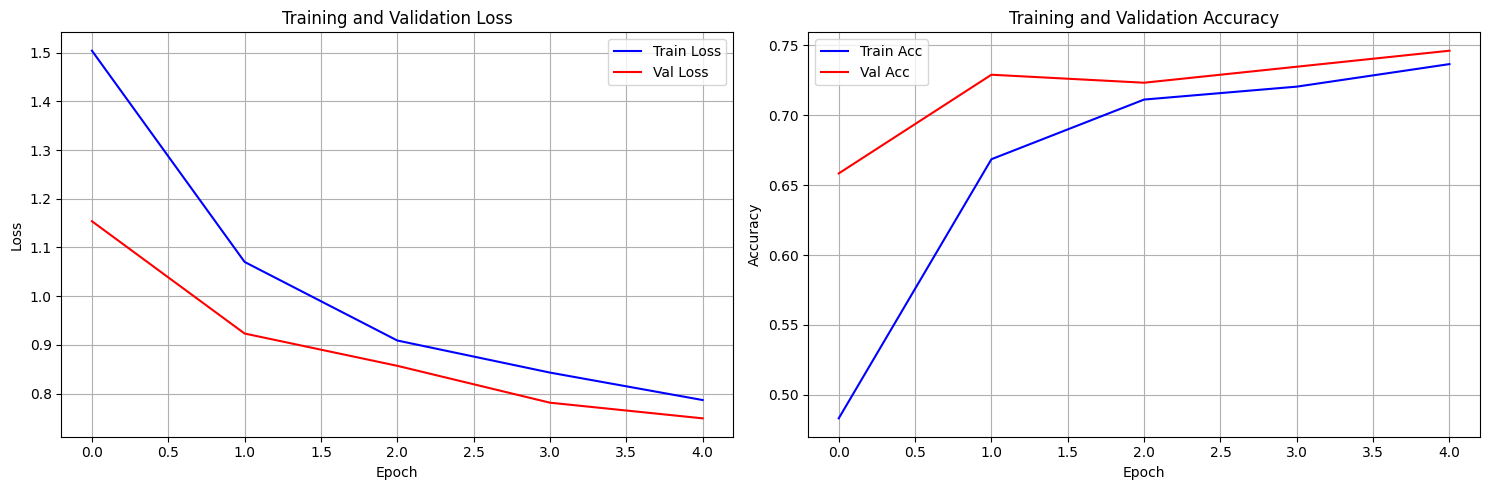

Final Training Accuracy: 0.7366
Final Validation Accuracy: 0.7462
Best Validation Accuracy: 0.7462


In [17]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', color='blue')
plt.plot(val_accs, label='Val Acc', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")
print(f"Best Validation Accuracy: {best_acc:.4f}")


## 8. Model Evaluation


Loading best model for evaluation...


Test Loss: 0.7197
Test Accuracy: 0.7434

Classification Report:
                        precision    recall  f1-score   support

1. Tea algal leaf spot       0.73      0.51      0.60        43
       2. Brown Blight       0.77      0.38      0.51        52
        3. Gray Blight       0.67      0.77      0.72       102
         4. Helopeltis       0.69      0.77      0.73        62
         5. Red spider       0.65      0.60      0.62        52
    6. Green mirid bug       0.77      0.85      0.81       129
       7. Healthy leaf       0.87      0.93      0.90        94

              accuracy                           0.74       534
             macro avg       0.74      0.69      0.70       534
          weighted avg       0.74      0.74      0.73       534



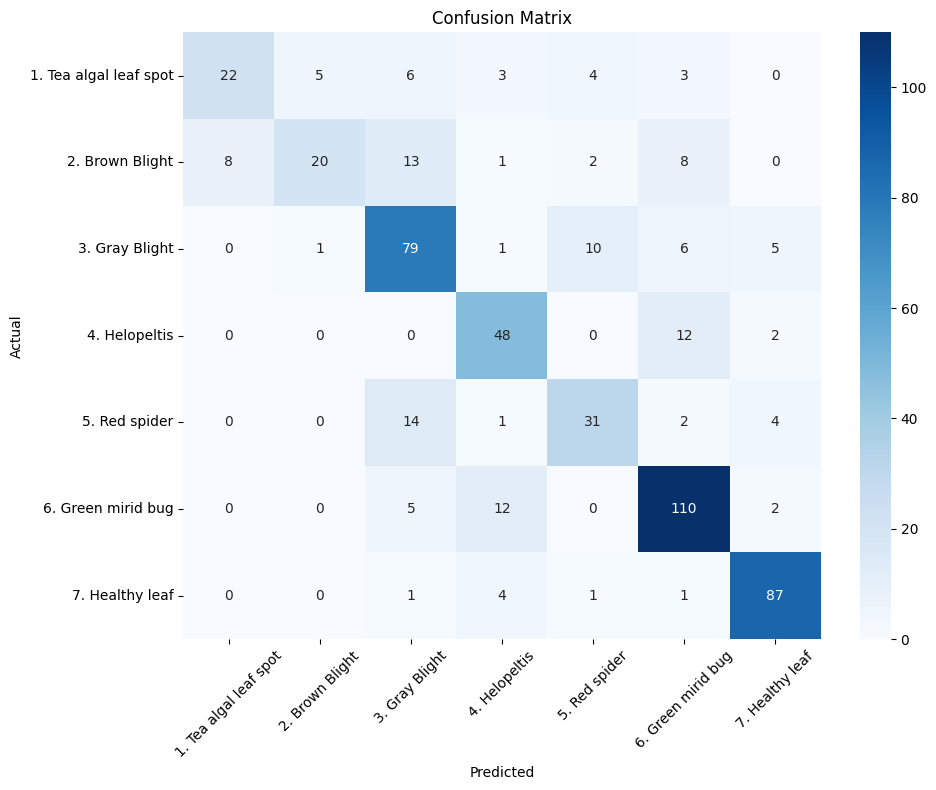

In [18]:
# Load best model and evaluate on test set
if os.path.exists("best_model.pth"):
    print("Loading best model for evaluation...")
    checkpoint = torch.load("best_model.pth", map_location=device)
    model.load_state_dict(checkpoint["model"])

    # Evaluate on test set
    if test_loader:
        test_loss, test_acc, test_preds, test_targets = evaluate(model, test_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(test_targets, test_preds, target_names=classes))

        # Confusion matrix
        cm = confusion_matrix(test_targets, test_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("No test set available for evaluation")
else:
    print("No saved model found")


## 9. Sample Predictions


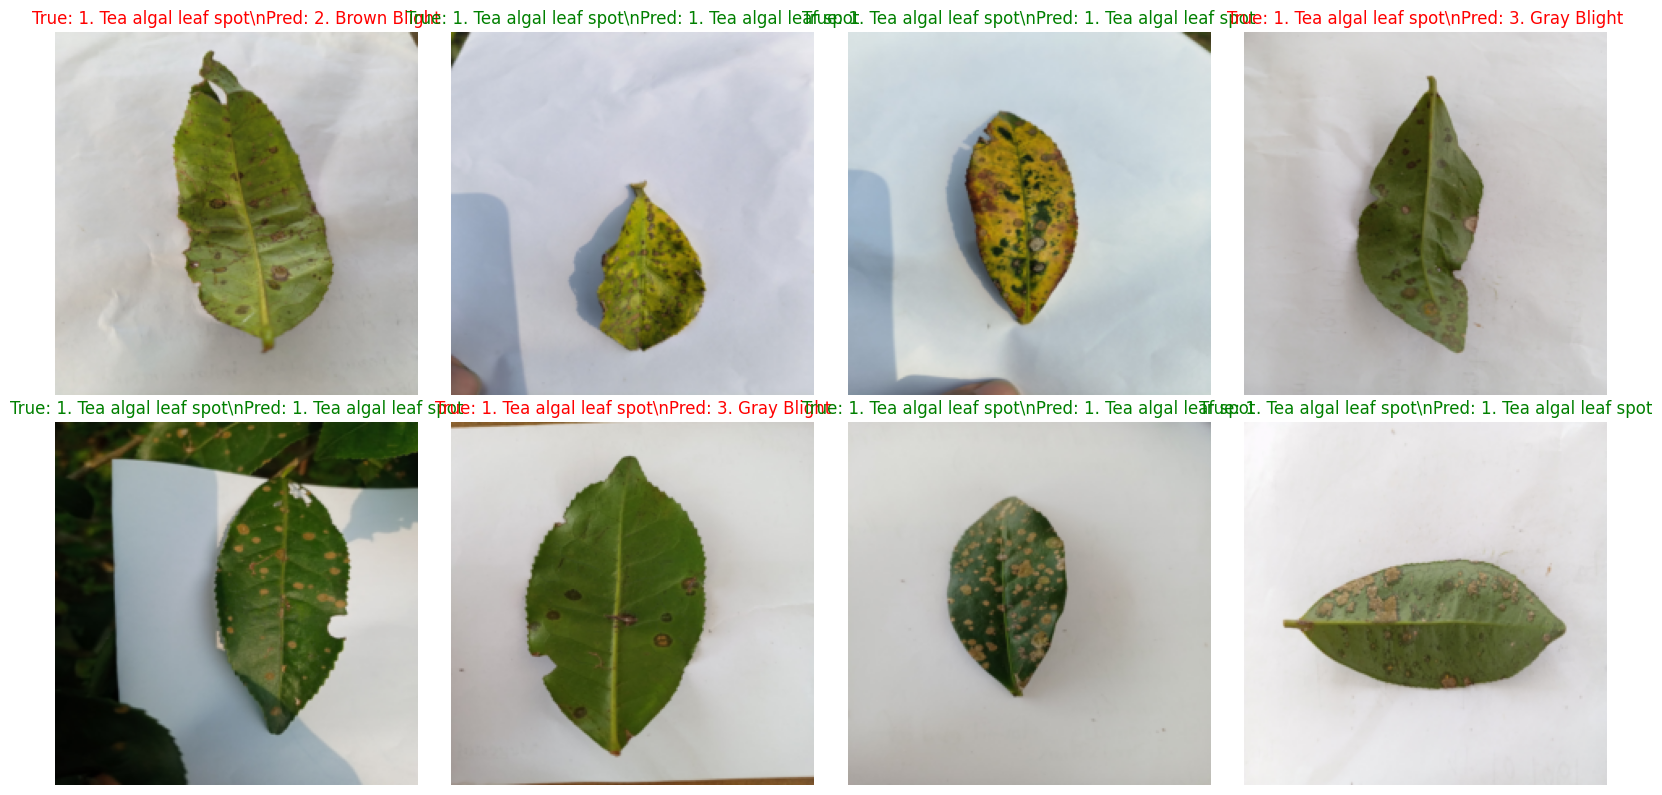

In [23]:
# Sample predictions on test images
import matplotlib.pyplot as plt
from torchvision import transforms
import random

def predict_sample_images(model, test_loader, classes, device, num_samples=8):
    model.eval()

    # Get a batch of test images
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Select random samples
    indices = random.sample(range(len(images)), min(num_samples, len(images)))
    sample_images = images[indices]
    sample_labels = labels[indices]

    # Make predictions
    with torch.no_grad():
        sample_images = sample_images.to(device)
        outputs = model(sample_images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()

    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(len(sample_images)):
        # Denormalize image for display
        img = sample_images[i].cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)

        axes[i].imshow(img)
        axes[i].set_title(f'True: {classes[sample_labels[i]]}\\nPred: {classes[predicted[i]]}',
                         color='green' if sample_labels[i] == predicted[i] else 'red')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Run sample predictions
if test_loader:
    predict_sample_images(model, test_loader, classes, device)
else:
    print("No test loader available for sample predictions")


## 9. Sample Predictions

This section demonstrates how the **trained MobileNetV2 model** performs on a few sample images from the **test dataset**. For each sample image, the code shows the actual tea leaf disease (the "True" label) and the disease predicted by the model (the "Pred" label). The title color indicates if the **final predicted** class matches the true class.

## 10. MobileNetV2 Fine-tuning Options

You can experiment with different MobileNetV2 configurations:

### Training Strategies:
1. **Frozen Backbone** (current): Only train the classifier layer
2. **Unfrozen Backbone**: Train the entire model (slower but potentially better)
3. **Gradual Unfreezing**: Start frozen, then unfreeze layers progressively

### Hyperparameter Options:
- **Learning Rate**: 0.001, 0.0003, 0.0001
- **Batch Size**: 16, 32, 64
- **Epochs**: 10, 20, 30
- **Image Size**: 224, 256, 288

### Advanced Training:
Run this cell to try unfreezing the backbone for fine-tuning:


In [21]:
# MobileNetV2 Fine-tuning Options
def unfreeze_backbone_and_continue_training(model, epochs=5, learning_rate=0.0001):
    """
    Unfreeze the MobileNetV2 backbone and continue training with lower learning rate

    Args:
        model: The trained MobileNetV2 model
        epochs: Number of additional epochs to train
        learning_rate: Lower learning rate for fine-tuning
    """
    print("Unfreezing MobileNetV2 backbone for fine-tuning...")

    # Unfreeze all parameters
    for param in model.parameters():
        param.requires_grad = True

    # Create new optimizer with lower learning rate
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler(enabled=AMP)

    print(f"Fine-tuning for {epochs} epochs with learning rate {learning_rate}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Continue training
    for epoch in range(1, epochs + 1):
        t0 = time.time()

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler if AMP else None)

        # Validate
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

        dt = time.time() - t0

        print(f"[Fine-tune {epoch:02d}/{epochs}] {dt:.1f}s  train: loss={train_loss:.4f} acc={train_acc:.4f} | val: loss={val_loss:.4f} acc={val_acc:.4f}")

        # Save if better
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({"model": model.state_dict(), "classes": classes}, "best_model_finetuned.pth")
            print(f"✓ Saved fine-tuned model (val_acc={best_acc:.4f})")

    return best_acc

# Uncomment the line below to run fine-tuning
# best_acc = unfreeze_backbone_and_continue_training(model, epochs=5, learning_rate=0.0001)

print("MobileNetV2 fine-tuning function ready. Uncomment the line above to run fine-tuning.")


MobileNetV2 fine-tuning function ready. Uncomment the line above to run fine-tuning.


## 11. Summary and Next Steps

### What We've Accomplished:
1. ✅ Set up the complete tea leaf disease detection pipeline
2. ✅ Downloaded and prepared the TeaLeafBD dataset
3. ✅ Implemented MobileNetV2 with transfer learning
4. ✅ Trained model with frozen backbone and data augmentation
5. ✅ Evaluated performance with comprehensive metrics
6. ✅ Visualized results and sample predictions

### Key Features:
- **MobileNetV2 Architecture**: Efficient and fast model for mobile deployment
- **Transfer Learning**: Pre-trained on ImageNet for better performance
- **Automatic Mixed Precision (AMP)**: Faster training with reduced memory usage
- **Data Augmentation**: Better generalization with rotation, flip, color jitter
- **Frozen/Unfrozen Training**: Flexible training strategies
- **Comprehensive Evaluation**: Confusion matrix and classification report
- **Sample Predictions**: Visual results with true vs predicted labels

### To Download Your Trained Model:
```python
from google.colab import files
files.download('best_model.pth')
```

### Next Steps:
1. **Fine-tuning**: Try unfreezing the backbone for better performance
2. **Hyperparameter tuning**: Experiment with learning rates, batch sizes
3. **Longer Training**: Increase epochs for better convergence
4. **Deployment**: Use the trained model for real-world tea leaf disease detection

### Tips for Better Results:
- Start with frozen backbone (faster training)
- Then unfreeze for fine-tuning (better accuracy)
- Try different learning rates: 0.0003 (frozen) → 0.0001 (unfrozen)
- Experiment with different batch sizes (16, 32, 64)
- Increase epochs gradually (10 → 20 → 30)
